In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
serenaraju_yawn_eye_dataset_new_path = kagglehub.dataset_download('serenaraju/yawn-eye-dataset-new')

print('Data source import complete.')


Using Colab cache for faster access to the 'yawn-eye-dataset-new' dataset.
Data source import complete.


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Define paths to the dataset on Kaggle
base_dir = '/kaggle/input/yawn-eye-dataset-new/dataset_new'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Define class names
class_names = ['closed', 'no_yawn', 'open', 'yawn']

In [ ]:
# Image data generators for augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 1975 images belonging to 4 classes.
Found 492 images belonging to 4 classes.
Found 433 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.regularizers import l2

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers with L2 regularization and increased dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
x = Dropout(0.6)(x)  # Increased dropout from 0.5 to 0.6
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
x = Dropout(0.6)(x)  # Increased dropout
predictions = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a slightly lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,046,212 (11.62 MB)

 Trainable params: 788,228 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Unfreeze layers after this index
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    epochs=20,  # Fewer epochs for fine-tuning
    validation_data=validation_generator,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.2857 - loss: 12.6469 - val_accuracy: 0.6524 - val_loss: 11.6321
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.3749 - loss: 12.0869 - val_accuracy: 0.7602 - val_loss: 11.3098
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.5021 - loss: 11.6804 - val_accuracy: 0.7825 - val_loss: 11.0975
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5519 - loss: 11.4818 - val_accuracy: 0.7825 - val_loss: 10.9357
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.6236 - loss: 11.3014 - val_accuracy: 0.7825 - val_loss: 10.8113
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.6895 - loss: 11.0651 - val_accuracy: 0.8171 - val_loss: 10.6969
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.7137 - loss: 10.9074 - val_accuracy: 0.8089 - val_loss: 10.5970
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.7476 - loss: 10.

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 95.84%


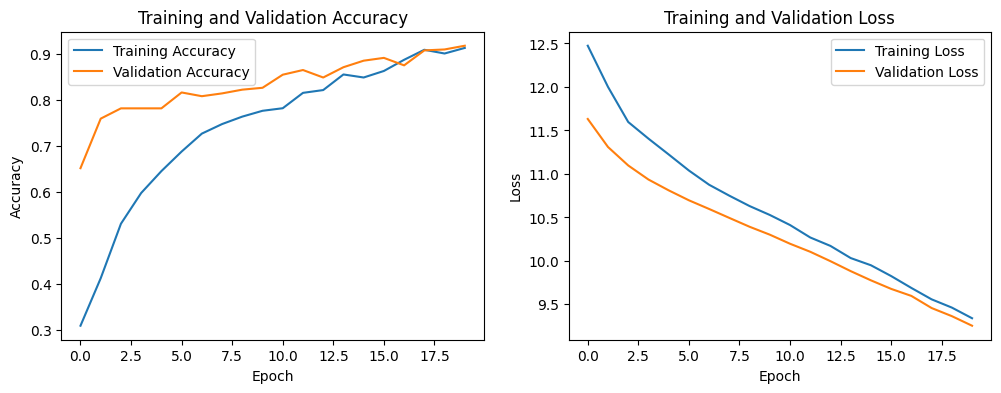

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 597ms/step
Classification Report:
              precision    recall  f1-score   support

      closed       0.97      0.99      0.98       109
     no_yawn       0.99      0.97      0.98       109
        open       0.95      0.92      0.93       109
        yawn       0.92      0.95      0.94       106

    accuracy                           0.96       433
   macro avg       0.96      0.96      0.96       433
weighted avg       0.96      0.96      0.96       433



28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 571ms/step


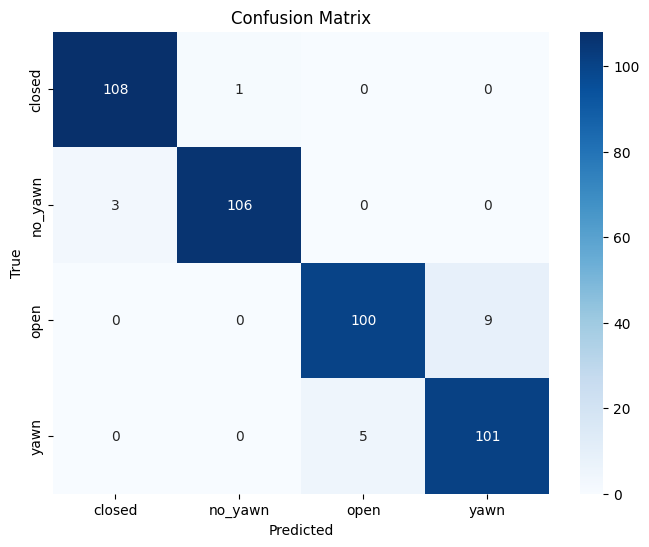

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get true labels and predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Total number of photos in test dataset: 433
Number of correct predictions out of 15: 8
Training Accuracy: 91.39%
Validation Accuracy: 91.87%
Test Accuracy: 95.84%


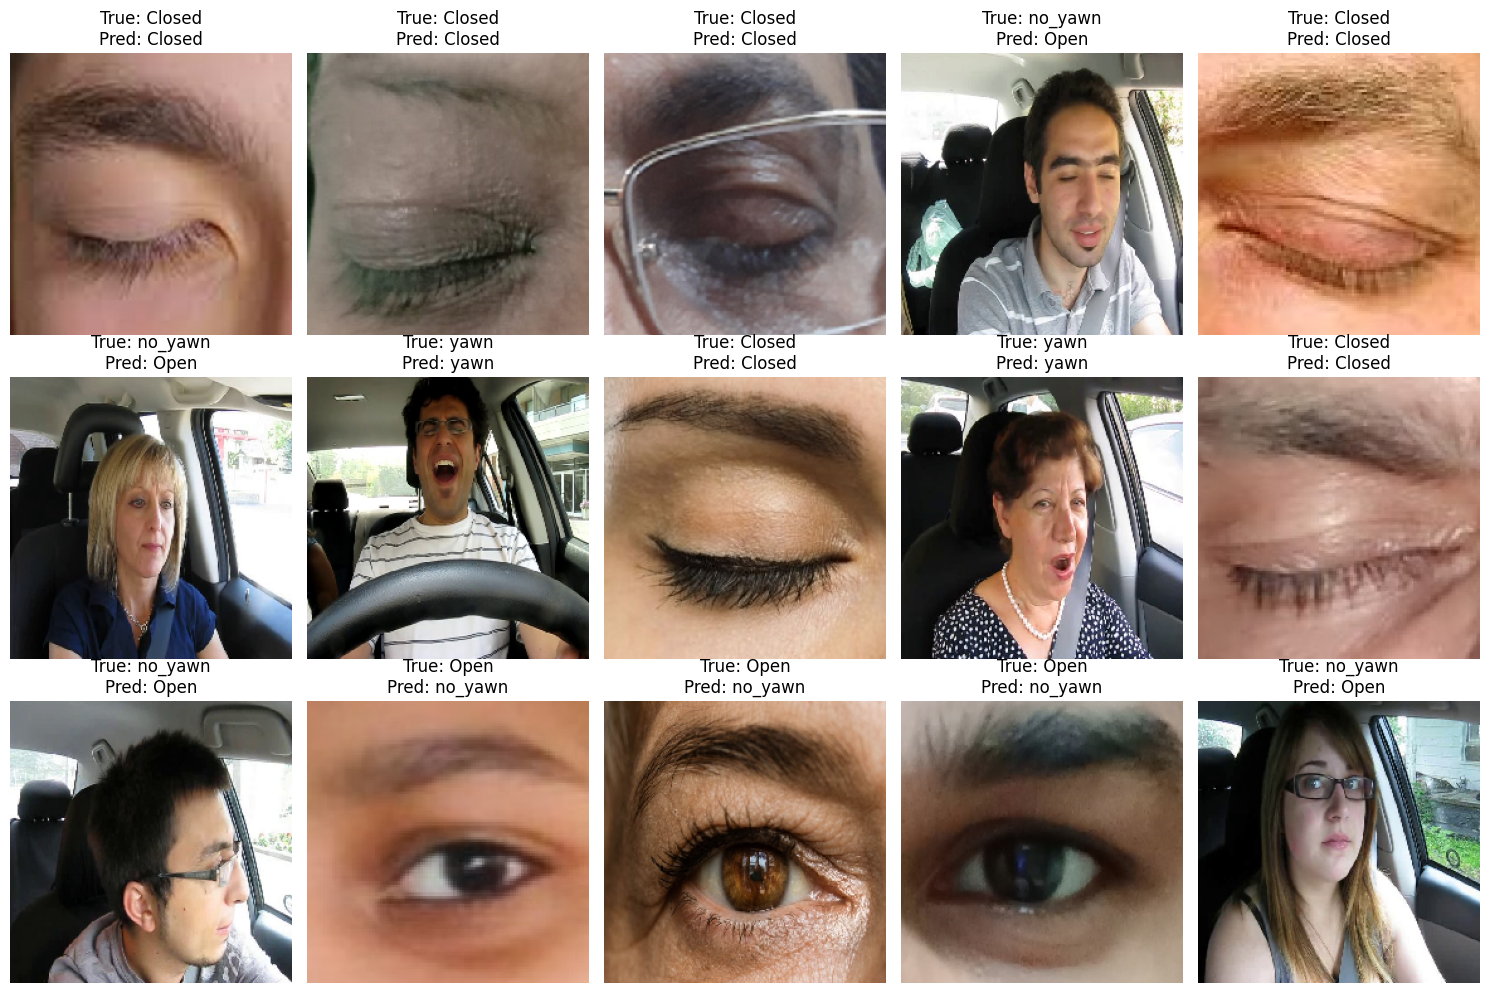

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define test directory and class names
test_dir = '/kaggle/input/yawn-eye-dataset-new/dataset_new/test'
class_names = ['Closed', 'no_yawn', 'Open', 'yawn']

# Verify test directory exists
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Test directory not found at: {test_dir}")

# Collect all image paths from test directory and count total photos
all_test_images = []
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    if not os.path.exists(class_path):
        print(f"Warning: Directory not found for class {class_name} at {class_path}")
        continue
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
    all_test_images.extend(images)

# Total number of photos in test dataset
total_photos = len(all_test_images)
print(f"Total number of photos in test dataset: {total_photos}")

# Check if images were found
if not all_test_images:
    raise ValueError("No images found in the test directory. Please check the dataset structure.")

# Randomly select up to 15 images
random_images = random.sample(all_test_images, min(15, len(all_test_images)))

# Initialize counter for correct predictions
correct_predictions = 0

# Prepare figure for plotting
plt.figure(figsize=(15, 10))

# Process and predict for each image
for i, img_path in enumerate(random_images):
    # Load and preprocess image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict class
    pred = model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(pred)]
    true_class = os.path.basename(os.path.dirname(img_path))

    # Check if prediction is correct
    if pred_class == true_class:
        correct_predictions += 1

    # Plot image with true and predicted labels
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis('off')

# Display number of correct predictions
print(f"Number of correct predictions out of 15: {correct_predictions}")

# Extract and display training, validation, and test accuracies
try:
    train_accuracy = history_fine.history['accuracy'][-1] * 100 if 'history_fine' in globals() else history.history['accuracy'][-1] * 100
    val_accuracy = history_fine.history['val_accuracy'][-1] * 100 if 'history_fine' in globals() else history.history['val_accuracy'][-1] * 100
except NameError:
    print("Error: Training history not found. Please run Chunk 5 (and Chunk 12 if fine-tuning was performed).")
    train_accuracy = val_accuracy = None

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
test_accuracy = test_accuracy * 100

if train_accuracy is not None:
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
model.save('model.h5')
print("Model saved as model.h5")

# Download the model file (for Colab)
try:
    from google.colab import files
    files.download('model.h5')
    print("Model file downloaded successfully!")
except ImportError:
    print("Not running in Colab - model.h5 saved locally")
except Exception as e:
    print(f"Download failed: {e}")
    print("You can manually download the model.h5 file from the Files panel")

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import traceback

def predict(image):
    try:
        if image is None:
            return "❌ No image provided."

        # Handle grayscale and RGBA
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        if image.shape[-1] == 4:
            image = image[..., :3]

        # Resize and normalize
        img = tf.image.resize(image, (128, 128))
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.expand_dims(img, axis=0)

        # Ensure model and class_names exist
        if 'model' not in globals():
            return "❌ Model not loaded."
        if 'class_names' not in globals():
            return "❌ class_names not defined."

        # Prediction
        pred = model.predict(img)
        class_idx = np.argmax(pred[0])
        class_name = class_names[class_idx]
        confidence = float(pred[0][class_idx])

        # Drowsy/Alert logic
        if class_name.lower() in ['closed', 'yawn']:
            status = "Drowsy"
            color = "#FF4C4C"  # red
        else:
            status = "Alert"
            color = "#4CAF50"  # green

        # HTML formatted output
        html_output = f"""
        <div style="border:2px solid {color}; border-radius:15px; padding:20px; max-width:400px; text-align:center; font-family:sans-serif;">
            <h2 style="color:{color};">{status}</h2>
            <p><b>Confidence:</b> {confidence*100:.2f}%</p>
        </div>
        """
        return html_output

    except Exception as e:
        error_msg = traceback.format_exc()
        return f"<pre style='color:red'>{error_msg}</pre>"

# Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=gr.HTML(),
    title="Driver Drowsiness Detection System",
    description="Upload an image of the driver's face to detect drowsiness. Shows only 'Drowsy' or 'Alert' and the confidence."
)

interface.launch(share=False, inline=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>